# Data Cleansing

In [18]:
# !pip install tensorflow
# !pip install tensorflow==2.12.0
# !pip install matplotlib

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Dense, Bidirectional, Dropout
from scipy.sparse import csr_matrix
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
import csv

# Function to write dataframe to csv file
def saveToCsv(fileName, df):
    with open(f'../data/{fileName}.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(df.columns)
        writer.writerows(df.values)

In [21]:
# Read in data from csv files
solar = pd.read_csv('../data/solar.csv')
ebikes = pd.read_csv('../data/ebikes.csv')
tesla = pd.read_csv('../data/tesla.csv')

In [22]:
# Remove new line characters
ebikes['content'] = ebikes['content'].str.replace(r"\n", "")
ebikes['content'] = ebikes['content'].str.replace(r"\r", "")
solar['content'] = solar['content'].str.replace(r"\n", "")
solar['content'] = solar['content'].str.replace(r"\r", "")
tesla['content'] = tesla['content'].str.replace(r"\n", "")
tesla['content'] = tesla['content'].str.replace(r"\r", "")

In [23]:
# Add labels to data
solar['label'] = 'solar'
ebikes['label'] = 'ebikes'
tesla['label'] = 'tesla'

In [24]:
# Print lenght of the datasets
print(f'len(solar) = {len(solar)}, len(ebikes) = {len(ebikes)}, len(tesla) = {len(tesla)}')

# Take first 1032 rows of the solar and Tesla datasets (to have the same number of rows as the ebikes dataset)


# Take same number of rows from the datasets
min_len = min(len(solar), len(ebikes), len(tesla))
solar = solar.head(min_len)
ebikes = ebikes.head(min_len)
tesla = tesla.head(min_len)
print(f'len(solar) = {len(solar)}, len(ebikes) = {len(ebikes)}, len(tesla) = {len(tesla)}')

len(solar) = 1204, len(ebikes) = 1032, len(tesla) = 1202
len(solar) = 1032, len(ebikes) = 1032, len(tesla) = 1032


# Classification Models

In [25]:
# Split the data into train and test sets (80% for training and 20% for testing)
solar_train, solar_test = train_test_split(solar, test_size=0.2, random_state=42)
ebikes_train, ebikes_test = train_test_split(ebikes, test_size=0.2, random_state=42)
tesla_train, tesla_test = train_test_split(tesla, test_size=0.2, random_state=42)

In [26]:
# Join the sets for train and test
train = pd.concat([solar_train, ebikes_train, tesla_train]).reset_index(drop=True)
test = pd.concat([solar_test, ebikes_test, tesla_test]).reset_index(drop=True)

In [27]:
# Extract the content and label columns from the dataframes
train_data = train["content"].values
train_labels = train["label"].values
test_data = test["content"].values
test_labels = test["label"].values

target_names = ['ebikes', 'solar', 'tesla']

### Naive Bayes with Count Vectorizer

In [28]:
# Conversione of texts into features
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data)
test_features = count_vect.transform(test_data)

# Training 
classifier = MultinomialNB()
classifier.fit(X_train_counts, train_labels)

# Test
predictions = classifier.predict(test_features)

print(classification_report(test_labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

      ebikes       1.00      0.99      1.00       207
       solar       0.97      1.00      0.98       207
       tesla       1.00      0.98      0.99       207

    accuracy                           0.99       621
   macro avg       0.99      0.99      0.99       621
weighted avg       0.99      0.99      0.99       621



### Naive Bayes with Tf-idf

In [29]:
# Conversione of texts into features
count_vect = TfidfVectorizer(max_features=2000)
X_train_counts = count_vect.fit_transform(train_data)
test_features = count_vect.transform(test_data)

# Training 
classifier = MultinomialNB()
classifier.fit(X_train_counts, train_labels)

# Test
predictions = classifier.predict(test_features)

print(classification_report(test_labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

      ebikes       1.00      0.99      0.99       207
       solar       0.96      1.00      0.98       207
       tesla       1.00      0.97      0.98       207

    accuracy                           0.99       621
   macro avg       0.99      0.99      0.99       621
weighted avg       0.99      0.99      0.99       621



### Logistic Regression with Count Vectorizer

In [30]:
# Conversione of texts into features
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data)
test_features = count_vect.transform(test_data)

# Training 
classifier = LogisticRegression()
classifier.fit(X_train_counts, train_labels)

# Test
predictions = classifier.predict(test_features)

print(classification_report(test_labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

      ebikes       1.00      1.00      1.00       207
       solar       0.98      1.00      0.99       207
       tesla       0.99      0.98      0.99       207

    accuracy                           0.99       621
   macro avg       0.99      0.99      0.99       621
weighted avg       0.99      0.99      0.99       621



/Users/petercatania/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Logistic Regression with Tf-idf

In [31]:
# Conversione of texts into features
count_vect = TfidfVectorizer(max_features=2000)
X_train_counts = count_vect.fit_transform(train_data)
test_features = count_vect.transform(test_data)

# Training 
classifier = LogisticRegression()
classifier.fit(X_train_counts, train_labels)

# Test
predictions = classifier.predict(test_features)

print(classification_report(test_labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

      ebikes       1.00      0.99      0.99       207
       solar       0.97      1.00      0.98       207
       tesla       0.99      0.98      0.98       207

    accuracy                           0.99       621
   macro avg       0.99      0.99      0.99       621
weighted avg       0.99      0.99      0.99       621



## Neural Networks

### 2 layers: Relu + Softmax

In [32]:
training_features = train_data
test_features = test_data
training_labels = train_labels
testing_labels = test_labels

label_encoder = LabelEncoder()
enc_training_labels = label_encoder.fit_transform(training_labels)
enc_testing_labels = label_encoder.transform(testing_labels)

# Conversione dei testi in features (TF-IDF)
vectorizer = TfidfVectorizer(max_features=2000)
training_features = vectorizer.fit_transform(training_features)
test_features = vectorizer.transform(test_features)

input_size = training_features.shape[1]  
hidden_size = 8
num_classes = len(target_names)
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model = Sequential([
    tf.keras.layers.Dense(hidden_size, input_shape=(input_size,), activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


dense_training_features = training_features.toarray()
dense_test_features = test_features.toarray()

X_train, X_val, y_train, y_val = train_test_split(dense_training_features, np.array(enc_training_labels), test_size=0.2, random_state=1492)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


_, test_accuracy = model.evaluate(dense_test_features, np.array(enc_testing_labels), verbose=0)
print(f'Test accuracy: {100 * test_accuracy:.2f}%')

y_pred = np.argmax(model.predict(dense_test_features), axis=1)
print(classification_report(enc_testing_labels, y_pred, labels = [0, 1, 2], target_names=target_names))

Epoch 1/20
124/124 [==============================] - 0s 953us/step - loss: 0.3087 - accuracy: 0.9040 - val_loss: 0.0247 - val_accuracy: 0.9980
Epoch 2/20
124/124 [==============================] - 0s 608us/step - loss: 0.0145 - accuracy: 0.9975 - val_loss: 0.0107 - val_accuracy: 0.9980
Epoch 3/20
124/124 [==============================] - 0s 587us/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.0304 - val_accuracy: 0.9838
Epoch 4/20
124/124 [==============================] - 0s 584us/step - loss: 0.0135 - accuracy: 0.9985 - val_loss: 0.0081 - val_accuracy: 0.9980
Epoch 5/20
124/124 [==============================] - 0s 572us/step - loss: 0.0058 - accuracy: 0.9995 - val_loss: 0.0067 - val_accuracy: 0.9980
Epoch 6/20
124/124 [==============================] - 0s 578us/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.0102 - val_accuracy: 0.9980
Epoch 7/20
124/124 [==============================] - 0s 573us/step - loss: 0.0042 - accuracy: 0.9995 - val_loss: 0.0069 - val_accuracy:

In [33]:
# Split the data into train and test sets (80% for training and 20% for testing)
solar_train, solar_test = train_test_split(solar, test_size=0.2, random_state=42)
ebikes_train, ebikes_test = train_test_split(ebikes, test_size=0.2, random_state=42)
tesla_train, tesla_test = train_test_split(tesla, test_size=0.2, random_state=42)

# Join the sets for train and test
train = pd.concat([solar_train, ebikes_train, tesla_train], axis=0)
test = pd.concat([solar_test, ebikes_test, tesla_test], axis=0)

# Extract the content and label columns from the dataframes
train_data = train["content"].values
train_labels = train["label"].values
test_data = test["content"].values
test_labels = test["label"].values

target_names = ['ebikes', 'solar', 'tesla']

## 2 GRU layers

Sequence length = 350 \
Embeddings size = 24 \
RNN units = 18 \
NN layers = 2 GRU layers \
100 epochs \
Batch size = 100

In [34]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_data)

X_train_sequences = tokenizer.texts_to_sequences(train_data)
X_test_sequences = tokenizer.texts_to_sequences(test_data)

max_sequence_len = max([len(x) for x in X_train_sequences])
max_sequence_len = 350

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_len, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_len, padding='post')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels)
y_test_encoded = label_encoder.transform(test_labels)
num_classes = len(set(train_labels))
total_words = len(tokenizer.word_index) + 1

assert num_classes == len(target_names) 

In [35]:
len(X_train_sequences), max_sequence_len, total_words

(2475, 350, 37030)

In [36]:
embedding_dim = 24
RNN_units = 18

# Define the model
model = Sequential()
model.add(Embedding(total_words, embedding_dim, input_length=max_sequence_len))
model.add(GRU(RNN_units, reset_after=False, return_sequences=True))
model.add(GRU(RNN_units, reset_after=False, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.0005,  
    patience=7,           
    verbose=1,            
    restore_best_weights=True)  

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 24)           888720    
                                                                 
 gru (GRU)                   (None, 350, 18)           2322      
                                                                 
 gru_1 (GRU)                 (None, 18)                1998      
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 57        
                                                                 
Total params: 893,097
Trainable params: 893,097
Non-trainable params: 0
_________________________________________________________________


In [37]:
epochs = 100
batch_size = 100
model.fit(X_train_padded, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

y_pred = np.argmax(model.predict(X_test_padded), axis=1)
print(classification_report(y_test_encoded, y_pred, labels = [0, 1, 2], target_names=target_names))

Epoch 1/100
20/20 [==============================] - 3s 117ms/step - loss: 1.0694 - accuracy: 0.5369 - val_loss: 1.3264 - val_accuracy: 0.0000e+00
Epoch 2/100
20/20 [==============================] - 2s 109ms/step - loss: 0.9788 - accuracy: 0.6217 - val_loss: 1.7218 - val_accuracy: 0.0000e+00
Epoch 3/100
20/20 [==============================] - 2s 108ms/step - loss: 0.8207 - accuracy: 0.7177 - val_loss: 1.6553 - val_accuracy: 0.0323
Epoch 4/100
20/20 [==============================] - 2s 109ms/step - loss: 0.5339 - accuracy: 0.8167 - val_loss: 1.3969 - val_accuracy: 0.2283
Epoch 5/100
20/20 [==============================] - 2s 109ms/step - loss: 0.2559 - accuracy: 0.9278 - val_loss: 0.6910 - val_accuracy: 0.7091
Epoch 6/100
20/20 [==============================] - 2s 111ms/step - loss: 0.1388 - accuracy: 0.9667 - val_loss: 0.9945 - val_accuracy: 0.7030
Epoch 7/100
20/20 [==============================] - 2s 112ms/step - loss: 0.0974 - accuracy: 0.9793 - val_loss: 0.6048 - val_accuracy

### Embeddings plot

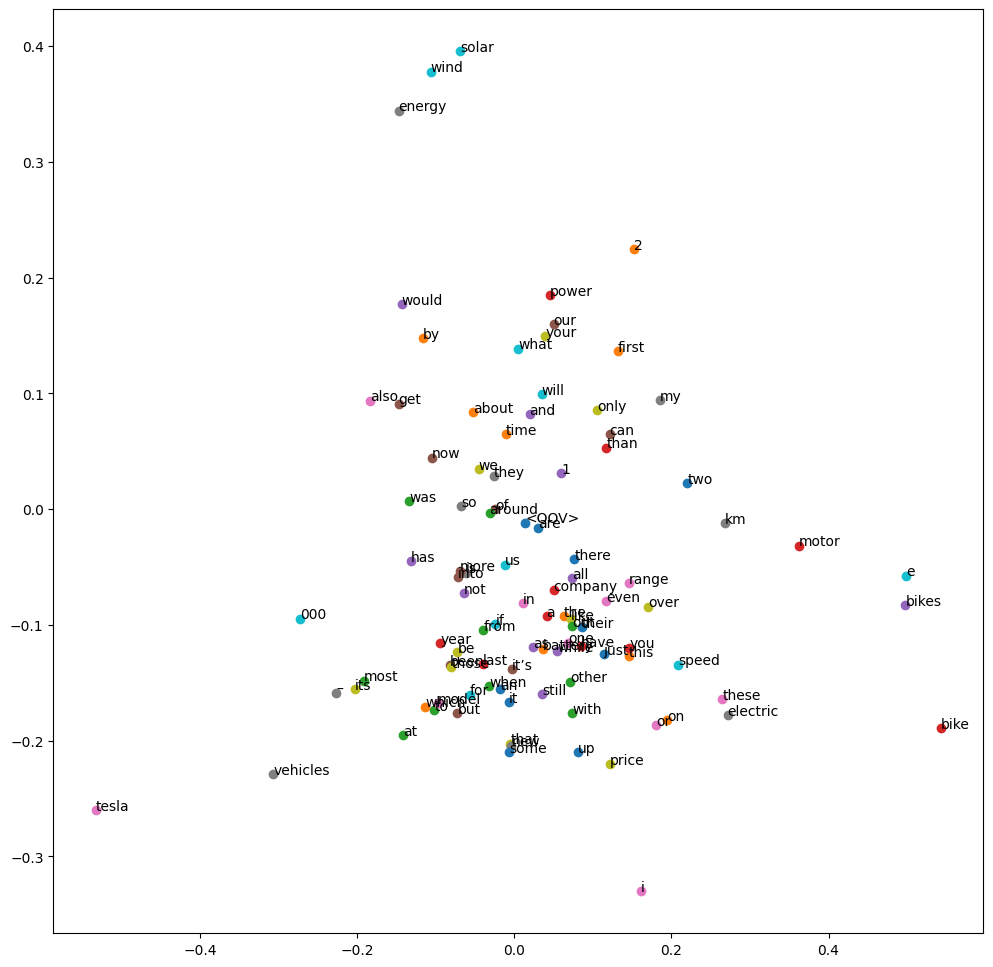

In [47]:
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding_weights_2d = pca.fit_transform(embedding_weights)

def plot_embeddings(embeddings, word_index, words_to_show=100):
    plt.figure(figsize=(12, 12))
    for i, word in enumerate(list(word_index.keys())[:words_to_show]):
        coords = embeddings[word_index[word]]
        plt.scatter(coords[0], coords[1])
        plt.annotate(word, (coords[0], coords[1]), fontsize=10)
    plt.show()

plot_embeddings(embedding_weights_2d, tokenizer.word_index, words_to_show=100)    

# Baseline

Classification based on the number of occurrencies of the name of the category itself or of it's minor variations, i.e. plural forms or different ways of spelling it (e.g. 'bike' / 'ebike' / 'e-bike' / 'bicycle' / 'e-bicycle').

In [39]:
import nltk
import string

# Creates and returns the vocabulary of a given document
def create_vocabulary(document, remove_stop_words=False, remove_punctuation=False, remove_numbers=False, remove_duplicates=False, docLanguage='english'):
    
    tokens = nltk.word_tokenize(document, language=docLanguage)
    stop_words = set(nltk.corpus.stopwords.words(docLanguage)) if remove_stop_words else []
    punctuation = set(string.punctuation) if remove_punctuation else []

    vocabulary = [t.lower() for t in tokens 
                if not ((t.lower() in stop_words)
                or (t.lower() in punctuation)
                or (t.lower().isdigit() and remove_numbers))]
    
    if remove_duplicates:
        return list(set(vocabulary))
    else:
        return vocabulary

In [40]:
# Classify a text based on its vocabulary into one of the given classes
def classify_text(text, classes):
    vocabulary = create_vocabulary(text, True, True, True)

    class_counts = {}
    for cl in classes:
        class_counts[cl] = 0

    for word in vocabulary:
        for cl in classes:
            if word in classes[cl]:
                class_counts[cl] += 1

    return max(class_counts, key=class_counts.get)

In [41]:
# Classify the given texts into the given classes and evaluate the results with the main classification metrics
def classify_texts_and_evaluate(texts, classes):
    texts['baseline'] = texts['content'].apply(lambda x: classify_text(x, classes))
    texts['baseline'].value_counts(normalize=True)
    
    print(classification_report(texts['label'].values, texts['baseline'].values, target_names=sorted(classes.keys())))

In [42]:
# Split the data into train and test sets (80% for training and 20% for testing)
solar_train, solar_test = train_test_split(solar, test_size=0.2, random_state=42)
ebikes_train, ebikes_test = train_test_split(ebikes, test_size=0.2, random_state=42)
tesla_train, tesla_test = train_test_split(tesla, test_size=0.2, random_state=42)

In [43]:
# Join the sets for train and test
train = pd.concat([solar_train, ebikes_train, tesla_train]).reset_index(drop=True)
test = pd.concat([solar_test, ebikes_test, tesla_test]).reset_index(drop=True)

# Define the classes and their keywords
classes = {'solar': ['panels', 'panel'], 
           'ebikes': ['ebike', 'ebikes', 'bike', 'bikes', 'e-bike', 'e-bikes', 'bicycle', 'bicycles', 'e-bicycle', 'e-bicycles'],  
           'tesla': ['tesla', 'model', 'elon', 'musk']}

In [44]:
# Trying to classify some dummy texts with the baseline approach
dummy_texts = pd.DataFrame({
    'content': ['I like solar panels', 'A friend of mine just bought a really expensive e-bike', 'I like e-bicycles but I like solar panels too, because with a solar panel I can recharge all my electric gadgets.', 'I want to be self-sufficient and respect the environment.', 'My two-wheels is so cool!', 'Elon Musk is the best', 'I want to buy a Tesla', 'I tried the Model 3 and it was amazing'], 
    'label': ['solar', 'ebikes', 'ebikes', 'solar', 'ebikes', 'tesla', 'tesla', 'tesla']})
classify_texts_and_evaluate(dummy_texts, classes)

              precision    recall  f1-score   support

      ebikes       1.00      0.33      0.50         3
       solar       0.50      1.00      0.67         2
       tesla       1.00      1.00      1.00         3

    accuracy                           0.75         8
   macro avg       0.83      0.78      0.72         8
weighted avg       0.88      0.75      0.73         8



In [45]:
# Now let's try with the real test set
classify_texts_and_evaluate(test, classes)

              precision    recall  f1-score   support

      ebikes       1.00      1.00      1.00       207
       solar       0.93      0.57      0.70       207
       tesla       0.69      0.96      0.80       207

    accuracy                           0.84       621
   macro avg       0.87      0.84      0.83       621
weighted avg       0.87      0.84      0.83       621



In [46]:
# Show the texts that were misclassified
test.loc[test['baseline'] != test['label']]

,date,content,label,baseline
0,2022/11/21,Quaise Energy is on a mission to prove that de...,solar,tesla
1,2022/12/29,"The world’s first floating offshore wind farm,...",solar,tesla
4,2023/03/16,Tesla is launching a new feature to help homeo...,solar,tesla
5,2023/03/16,Tesla is launching a new feature to help homeo...,solar,tesla
6,2022/01/19,The US Department of Interior’s Bureau of Ocea...,solar,tesla
...,...,...,...,...
490,2023/03/23,Lucid Motors is in the process of delivering a...,tesla,solar
499,2023/03/23,Lucid Motors is in the process of delivering a...,tesla,solar
546,2023/03/23,Lucid Motors is in the process of delivering a...,tesla,solar
582,2023/03/23,Lucid Motors is in the process of delivering a...,tesla,solar
